# Lab 14: Time Series II: ARIMA modelling

## Learning goals

- Understand how to make a simple forecast with an ARIMA model
- How to run an ARIMA model with an exogenous variable, and how to create scenarios with exogenous variables
- Modelling seasonality with ARIMA modelling. 

## Literature
- [FPP3 Ch. 9](https://otexts.com/fpp3/arima.html)

In this lab and the next, we will use some simple time series forecasting tools to make forecasts and scenarios. In this lab we will investigate various univariate forecasting tools: Basically, modeling the behavior of a time series we are interested in, and then propagating it forward. This will include modeling both the dynamics of the mean value of a time series, as well as modeling the volatility. 

In the next lab (lab 6) we will extend this modeling to include the influence of other variables. In particular, we will focus on creating scenarios for the electricity price under different quota prices on the European carbon trading market (ETS).

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spt

import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns




In [35]:
from cycler import cycler

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)





## Power prices and ETS prices

First, lets load in some data on power prices as well as prices on carbon permits in the ETS trading scheme. 

I obtained carbon prices from UK think tank [EMBER](https://ember-climate.org/carbon-price-viewer/). The emissions are traded on the EEX exchange, and in principle you should be able to get prices from them as well, but their data is not particularly user friendly. 

In [71]:
ets = pd.read_csv("http://jmaurit.github.io/analytics/labs/data/eua-price.csv")
ets.columns = ["date", "ets_price"]

In [72]:
elspot = pd.read_csv("http://jmaurit.github.io/norwayeconomy/data_series/elspot.csv")

In [73]:
elspot["date"] = pd.to_datetime(elspot.date) #change "date" type to datetime 
ets["date"] = pd.to_datetime(ets.date)

In [75]:
ets["month"] = ets.date.dt.month
ets["year"] = ets.date.dt.year
ets_monthly = ets.groupby(["year", "month"])["ets_price"].aggregate(np.mean)
ets_monthly = ets_monthly.reset_index()
ets_monthly["day"] = 1
ets_monthly["date"] = pd.to_datetime(ets_monthly[["year", "month", "day"]])

In [76]:
ets_monthly

,year,month,ets_price,day,date
0,2008,4,25.855625,1,2008-04-01
1,2008,5,26.805500,1,2008-05-01
2,2008,6,29.095600,1,2008-06-01
3,2008,7,27.194500,1,2008-07-01
4,2008,8,25.712000,1,2008-08-01
...,...,...,...,...,...
137,2019,10,24.930500,1,2019-10-01
138,2019,11,24.525000,1,2019-11-01
139,2019,12,25.259900,1,2019-12-01
140,2020,1,24.401000,1,2020-01-01


In [77]:
ets_monthly = ets_monthly.loc[:,["date", "ets_price"]].copy()

In [81]:
dkprices = elspot.loc[:, ["date", "DK1", "DK2"]]
power_DF = dkprices.merge(ets_monthly, how="left", on="date")

In [82]:
power_DF

,date,DK1,DK2,ets_price
0,2000-01-01,1779,NaN,NaN
1,2000-02-01,1431,NaN,NaN
2,2000-03-01,1453,NaN,NaN
3,2000-04-01,1593,NaN,NaN
4,2000-05-01,1680,NaN,NaN
...,...,...,...,...
223,2018-08-01,5569,5684.0,19.0950
224,2018-09-01,4989,5179.0,21.4410
225,2018-10-01,4748,5090.0,19.3204
226,2018-11-01,5404,5468.0,19.5105


array([<AxesSubplot:xlabel='date'>, <AxesSubplot:xlabel='date'>,
       <AxesSubplot:xlabel='date'>], dtype=object)

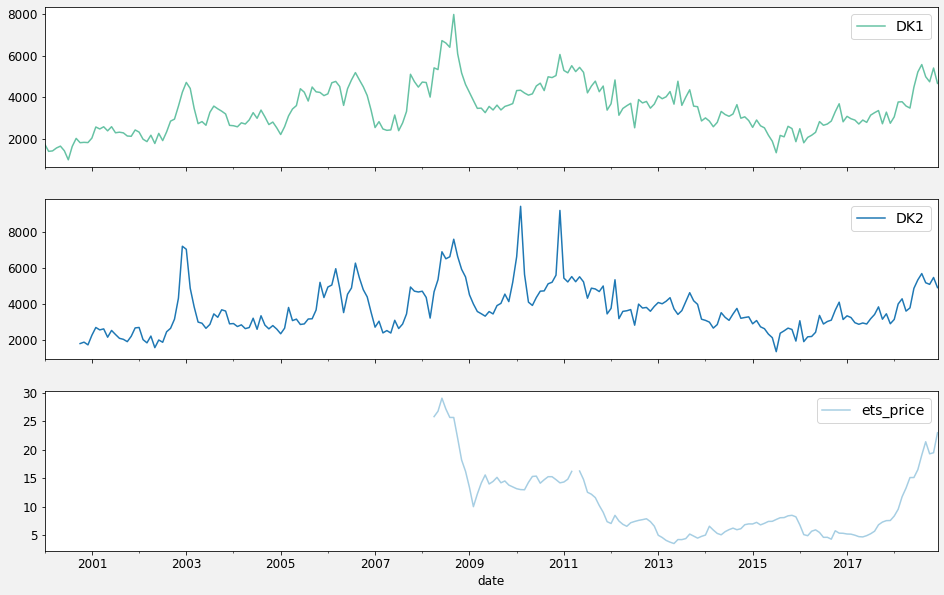

In [84]:
power_DF.set_index("date").plot(subplots=True)

To get power prices on similar scale as ets prices, we'll divide by 1000 (and thus prices will be per KWh and not MWh). Both power prices and carbon prices are in Euro.

In [85]:
power_DF["DK1"] = power_DF.DK1/1000
power_DF["DK2"] = power_DF.DK2/1000

## Forecasting ARIMA models

Now that we have our data, our goal is to put together a forecasting model of power prices. Our end goal is to put together a forecasting model that takes into account various future ETS prices, but we will wait until later to do that. 

In this lab, we will make use of some of the time series tools we learned in the previous lab, and then take a step further and turn those models into a forecasting tool. The forecasting tools we make use of here are in large part based on [Forecasting: Principles and Practice](https://otexts.com/fpp3/). It can be particularly useful to have read through [ch. 9](https://otexts.com/fpp3/arima.html) and [ch. 9](https://otexts.com/fpp3/dynamic.html).

## Forecasts based on ARIMA models

The AR model that we used in the previous lab is part of a larger class of models called ARIMA models: AR: Autoregressive, MA: Moving Average, and I: order of integration. 

 
We have already seen an AR model, where a variable is modeled as a function of its own lagged values. A [Moving Average model](https://otexts.com/fpp3/MA.html) is also dynamic, but here we model the dynamics in the model's error term (or the shocks of the model), not in the actual *y* values. 

We can write a MA model of order 1 (MA(1)) as: 

$y_t = c + \epsilon_t + \epsilon_{t-1}$

An MA model of order 2 (MA(2)) as: 

$y_t = c + \epsilon_t + \epsilon_{t-1} + \epsilon_{t-2}$

The economic intuition for such a model is that an exogenous shock in one period, can carry on to later periods. For example, the outbreak of the corona virus in the first half of 2020, continues to have reverberations for the oil price in the second half of the year, first half of 2021 and so on, even if the actual event was (optimistically) limited to the first half of 2020. 

An interesting and important fact [all AR models can also be written as MA models](https://otexts.com/fpp3/MA.html). And all MA models can be written as an AR model. As a practical matter, a time series with complex dynamics can often best be modeled as a combination of AR and MA terms. 

Taking a look at our data, we might question whether it is stationary.


In [87]:
from statsmodels.tsa.stattools import adfuller

In [91]:
dftest1 = adfuller(power_DF.DK1[power_DF.DK1.notna()], autolag="AIC") 
dftest2 = adfuller(power_DF.DK2[power_DF.DK2.notna()], autolag="AIC") 
dftest3 = adfuller(power_DF.ets_price[power_DF.ets_price.notna()], autolag="AIC") 

print(dftest1)
print(dftest2)
print(dftest3)

(-3.0300010562825705, 0.0321860862960016, 1, 226, {'1%': -3.4596204846395824, '5%': -2.8744153028455948, '10%': -2.5736320761218576}, 311.72544159766596)
(-4.729780894268516, 7.395542859557127e-05, 0, 218, {'1%': -3.460707667106296, '5%': -2.874891213486339, '10%': -2.573885987711472}, 475.6251266183657)
(-2.319850116320814, 0.16564581028701914, 4, 123, {'1%': -3.4846672514209773, '5%': -2.8853397507076006, '10%': -2.5794629869786503}, 282.8400173677891)


Looking at the test statistics and p-values, it looks like we can reject the null of non-stationarity for the two price series, though the p-value for the DK1 series was .03 -- not far from a .05 critical value.  

We should consider ETS prices to be non-stationary.

Let us focus on the DK2 series - let us investigate the form of the autocorrelations in the data: 
    



In [99]:
DK2_price = power_DF.loc[power_DF.DK2.notna(), ["date", "DK2"]].set_index("date")

In [102]:
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


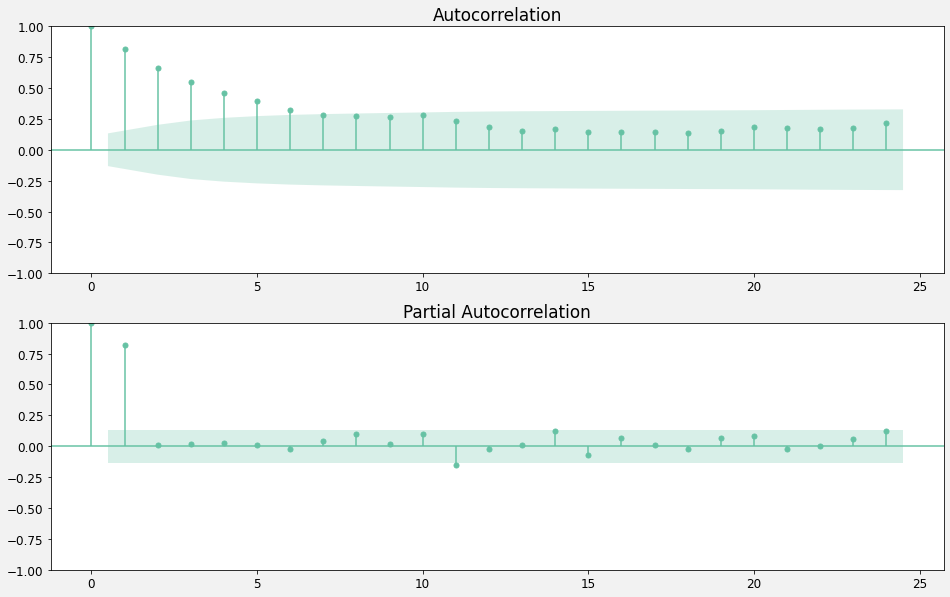

In [107]:
fig, ax = plt.subplots(2,1)
plot_acf(DK2_price, ax=ax[0])
plot_pacf(DK2_price, ax=ax[1])
plt.show()

A good guess on the autoregressive structure is 1 ar term - based on the partial autocorrelation chart. We can try creating an ARIMA model based on 

In [108]:
from statsmodels.tsa.arima.model import ARIMA

In [109]:
arimaMod0 = ARIMA(DK2_price, order=(1,0,0)).fit()

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


Notice the *order* parameter, here you could enter the order of the model according to (AR, I, MA). We fit a model with a single AR term

In [112]:
arimaMod0.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    DK2   No. Observations:                  219
Model:                 ARIMA(1, 0, 0)   Log Likelihood                -249.496
Date:                Fri, 25 Feb 2022   AIC                            504.991
Time:                        09:44:59   BIC                            515.159
Sample:                    10-01-2000   HQIC                           509.098
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7208      0.355     10.481      0.000       3.025       4.417
ar.L1          0.8195      0.026     31.771      0.000       0.769       0.870
sigma2         0.5687      0.029     19.428      0.000       0.511       0.626
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):               366.25
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               0.45   Skew:                             0.96
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.04
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Let us try an alternative model, adding an ma term

In [114]:
arimaMod1 = ARIMA(DK2_price, order=(1,0,1)).fit()
arimaMod1.summary()

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    DK2   No. Observations:                  219
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -249.453
Date:                Fri, 25 Feb 2022   AIC                            506.906
Time:                        09:45:28   BIC                            520.463
Sample:                    10-01-2000   HQIC                           512.381
                         - 12-01-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.7204      0.363     10.246      0.000       3.009       4.432
ar.L1          0.8279      0.044     18.649      0.000       0.741       0.915
ma.L1         -0.0251      0.069     -0.363      0.716      -0.160       0.110
sigma2         0.5684      0.029     19.320      0.000       0.511       0.626
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               367.13
Prob(Q):                              0.97   Prob(JB):                         0.00
Heteroskedasticity (H):               0.44   Skew:                             0.99
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.03
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

A common way of comparing models is to look at the information criterion: Akaike Information criteria (AIC) and BIC (Bayesian Information Criteria). At a basic intuitive model, these criteria say something about the "information loss" of the model, and we want to choose the model that minimizes this information loss. 

Another way of looking at it, is that these information criteria balance the competing aims of variance and bias. By adding extra variables we can avoid the *bias* or *underfitting* of not capturing relevant parts of the data. But adding extra variables can also result in high *variance* or *overfitting*, that is a model that is sensitive to small, inconsequential changes in the data. 

Adding an MA term to our regression seems to increase the information loss, both measured as AIC and BIC. So let us stay with our AR(1) formulation

In [124]:
fitted = arimaMod0.fittedvalues

We can also plot the actual versus fitted values: 

<AxesSubplot:xlabel='date'>

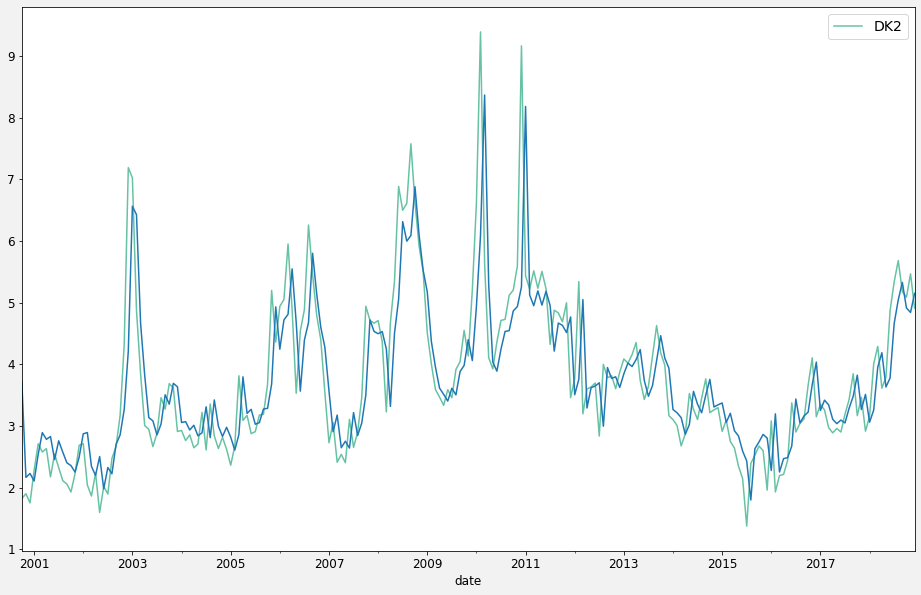

In [125]:
fig, ax = plt.subplots()
DK2_price.plot(ax=ax)
fitted.plot(ax=ax)

The simple model is able to track the data quite well. Let's look at the residuals as well: 

In [160]:
resids = arimaMod0.resid

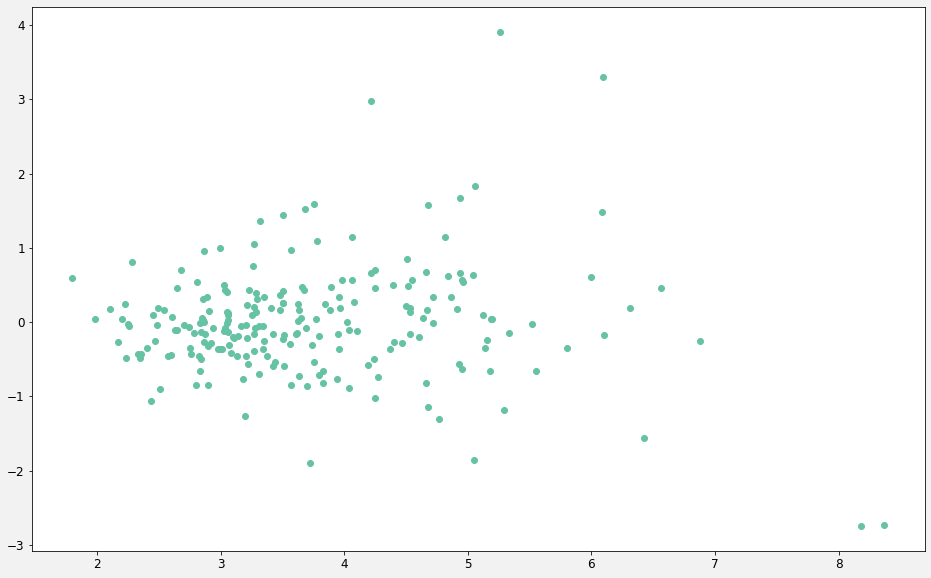

In [161]:
fig, ax = plt.subplots()
ax.scatter(x=fitted, y=resids)

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


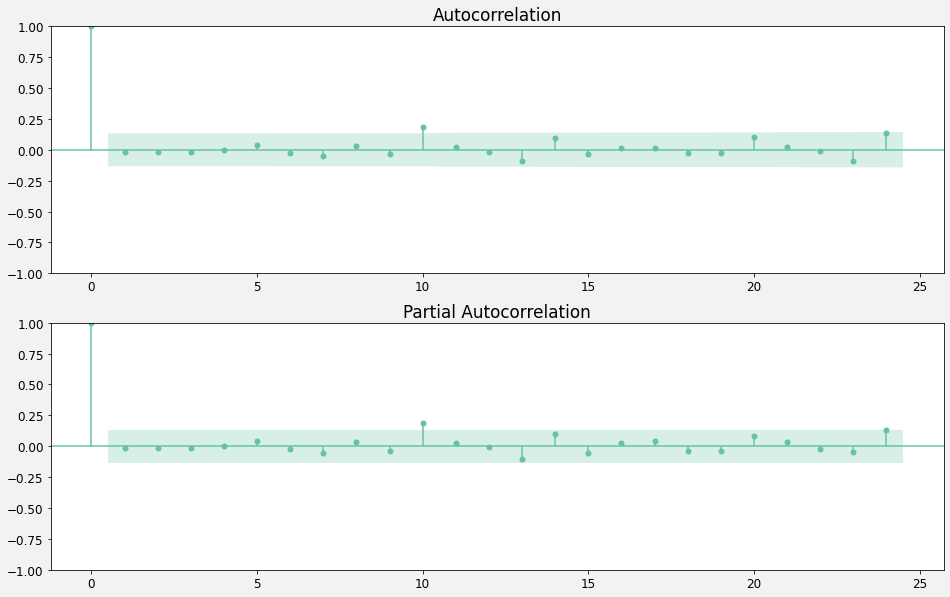

In [162]:
fig, ax = plt.subplots(2,1)
plot_acf(resids, ax=ax[0])
plot_pacf(resids, ax=ax[1])
plt.show()

No obvious autocorrelation or other structure left in the residual

Now let's create a simple forecast based on our model

In [150]:
forecast1= arimaMod0.get_forecast(steps=12).summary_frame()

In [151]:
forecast1 = forecast1.reset_index()
forecast1 = forecast1.rename(columns = {"index":"date"})

In [153]:
forecast1

DK2,date,mean,mean_se,mean_ci_lower,mean_ci_upper
0,2019-01-01,4.696226,0.754094,3.218229,6.174223
1,2019-02-01,4.520209,0.974988,2.609267,6.431150
2,2019-03-01,4.375954,1.098698,2.222545,6.529363
3,2019-04-01,4.257730,1.174497,1.955759,6.559701
4,2019-05-01,4.160840,1.222772,1.764251,6.557430
5,2019-06-01,4.081434,1.254154,1.623337,6.539531
6,2019-07-01,4.016357,1.274799,1.517798,6.514917
7,2019-08-01,3.963023,1.288479,1.437651,6.488396
8,2019-09-01,3.919314,1.297586,1.376091,6.462537
9,2019-10-01,3.883492,1.303668,1.328350,6.438634


<AxesSubplot:xlabel='date'>

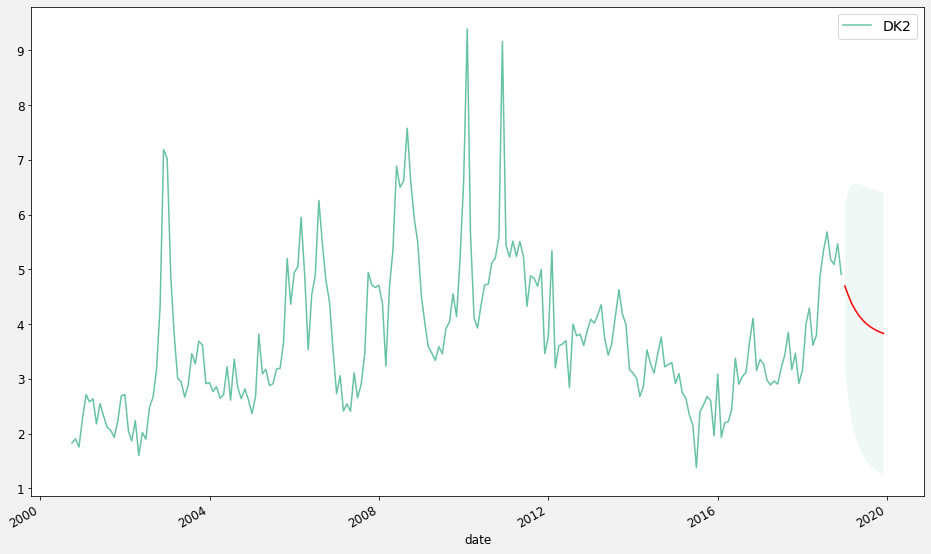

In [157]:
fig, ax = plt.subplots()
ax.plot(forecast1["date"], forecast1["mean"], color="red")
ax.fill_between(forecast1["date"], forecast1["mean_ci_lower"], forecast1["mean_ci_upper"], alpha=.1)
DK2_price.plot(ax=ax)


### Adding an exogenous regressor to our model. 

Now we wish to add an explanatory variable to our analysis - the ETS price. We need series that are of the same length, so let us extract the two series from our dataframe, dependent on whether there exists ets data: 

In [208]:
DK2_price = power_DF.loc[power_DF.ets_price.notna(), ["date", "DK2"]].set_index("date")
ets_price = power_DF.loc[power_DF.ets_price.notna(), ["date", "ets_price"]].set_index("date")

In [211]:
DK2_price

,DK2
date,
2008-04-01,4.680
2008-05-01,5.350
2008-06-01,6.886
2008-07-01,6.500
2008-08-01,6.611
...,...
2018-08-01,5.684
2018-09-01,5.179
2018-10-01,5.090


In [223]:
arimaMod2 = ARIMA(DK2_price,ets_price, order=(1,1,0)).fit()
arimaMod2.summary()

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'
/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:593: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  warnings.warn('A date index has been provided, but it has no'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                    DK2   No. Observations:                  128
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -155.242
Date:                Fri, 25 Feb 2022   AIC                            316.484
Time:                        12:32:39   BIC                            325.017
Sample:                             0   HQIC                           319.951
                                - 128                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ets_price      0.1007      0.076      1.330      0.184      -0.048       0.249
ar.L1         -0.2034      0.039     -5.219      0.000      -0.280      -0.127
sigma2         0.6747      0.043     15.536      0.000       0.590       0.760
===================================================================================
Ljung-Box (L1) (Q):                   0.19   Jarque-Bera (JB):               218.26
Prob(Q):                              0.66   Prob(JB):                         0.00
Heteroskedasticity (H):               0.18   Skew:                             0.15
Prob(H) (two-sided):                  0.00   Kurtosis:                         9.42
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

The first thing to notice is that our model order is now (AR=1, I=1, MA=0). The I=1 mean integrated of order 1, which basically is a fancy way of saying that a first-difference of both series is taken before running the regression. 

Now let's create a forecast

In [224]:
ets_price_high = np.linspace(25,100,12)
ets_price_low = np.repeat(25,12)

In [225]:
forecast_highETS = arimaMod2.get_forecast(exog=ets_price_high, steps=12).summary_frame()

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [226]:
forecast_highETS

DK2,mean,mean_se,mean_ci_lower,mean_ci_upper
128,5.294801,0.821411,3.684865,6.904738
129,5.943776,1.050190,3.885441,8.002112
130,6.638115,1.255667,4.177052,9.099178
131,7.323228,1.428649,4.523128,10.123328
132,8.010217,1.583443,4.906727,11.113708
133,8.696825,1.724284,5.317291,12.076358
134,9.383510,1.854480,5.748796,13.018224
135,10.070180,1.976113,6.197069,13.943290
136,10.756852,2.090682,6.659190,14.854514
137,11.443524,2.199291,7.132993,15.754056


In [227]:
forecast_lowETS = arimaMod2.get_forecast(exog=ets_price_low, steps=12).summary_frame()

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:390: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [228]:
forecast_highETS["date"] = pd.date_range(start='1/1/2019', freq='MS', periods=12)
forecast_lowETS["date"] = pd.date_range(start='1/1/2019', freq='MS', periods=12)



#forecast_highETS = forecast_highETS.rename(columns = {"index":"date"})


#forecast_lowETS = forecast_lowETS.rename(columns = {"index":"date"})

In [229]:
forecast_highETS

DK2,mean,mean_se,mean_ci_lower,mean_ci_upper,date
128,5.294801,0.821411,3.684865,6.904738,2019-01-01
129,5.943776,1.050190,3.885441,8.002112,2019-02-01
130,6.638115,1.255667,4.177052,9.099178,2019-03-01
131,7.323228,1.428649,4.523128,10.123328,2019-04-01
132,8.010217,1.583443,4.906727,11.113708,2019-05-01
133,8.696825,1.724284,5.317291,12.076358,2019-06-01
134,9.383510,1.854480,5.748796,13.018224,2019-07-01
135,10.070180,1.976113,6.197069,13.943290,2019-08-01
136,10.756852,2.090682,6.659190,14.854514,2019-09-01
137,11.443524,2.199291,7.132993,15.754056,2019-10-01


In [230]:
forecast_lowETS

DK2,mean,mean_se,mean_ci_lower,mean_ci_upper,date
128,5.294801,0.821411,3.684865,6.904738,2019-01-01
129,5.257104,1.050190,3.198769,7.315439,2019-02-01
130,5.264771,1.255667,2.803708,7.725834,2019-03-01
131,5.263211,1.428649,2.463112,8.063311,2019-04-01
132,5.263529,1.583443,2.160038,8.367019,2019-05-01
133,5.263464,1.724284,1.883930,8.642998,2019-06-01
134,5.263477,1.854480,1.628763,8.898191,2019-07-01
135,5.263474,1.976113,1.390364,9.136585,2019-08-01
136,5.263475,2.090682,1.165813,9.361137,2019-09-01
137,5.263475,2.199291,0.952944,9.574006,2019-10-01


<AxesSubplot:xlabel='date'>

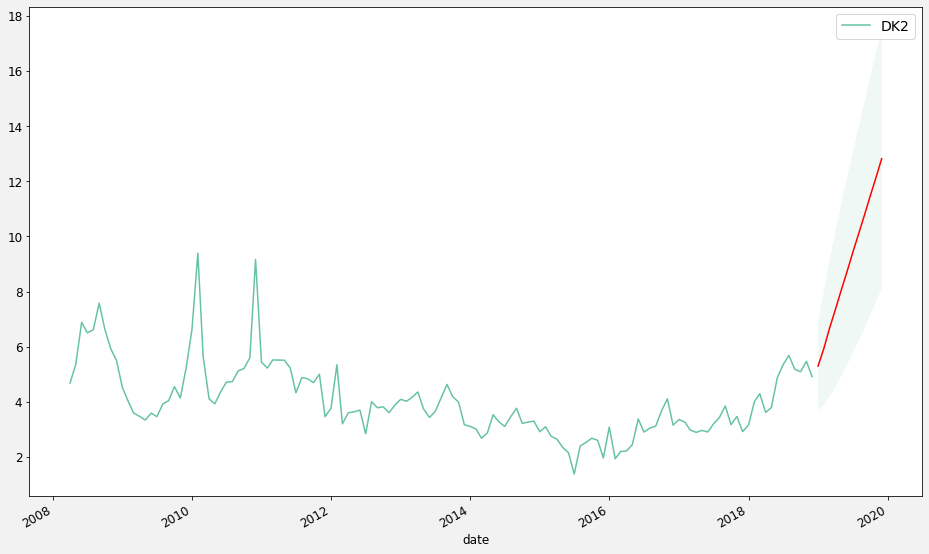

In [232]:
fig, ax = plt.subplots()
ax.plot(forecast_highETS["date"], forecast_highETS["mean"], color="red")
ax.fill_between(forecast_highETS["date"], forecast_highETS["mean_ci_lower"], forecast_highETS["mean_ci_upper"], alpha=.1)
DK2_price.plot(ax=ax)

<AxesSubplot:xlabel='date'>

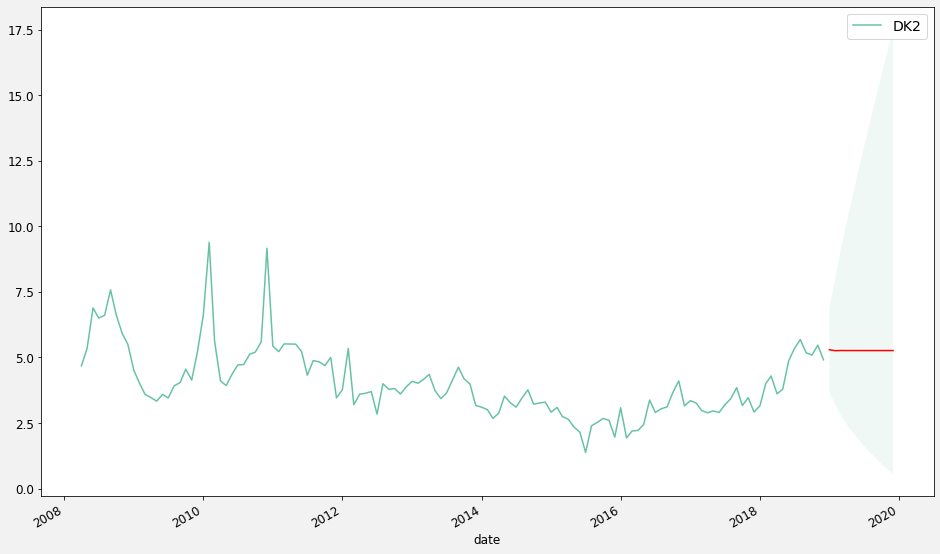

In [233]:
fig, ax = plt.subplots()
ax.plot(forecast_lowETS["date"], forecast_lowETS["mean"], color="red")
ax.fill_between(forecast_lowETS["date"], forecast_lowETS["mean_ci_lower"], forecast_highETS["mean_ci_upper"], alpha=.1)
DK2_price.plot(ax=ax)

So now we have created two scenarious - one where we assume that the ETS price stays constant, and another where we assume that it rises to 100 EUR/ton. We see starkly different forecasts for the prices. Such scenario generation in many different situations: For example, risk analysis or operational planning. 

PS: Prices climbed steadily and are currently around 90 EUR/TON: 

https://ember-climate.org/data/carbon-price-viewer/

### Seasonality

A lot of time-series, especially with high frequency, have seasonality. That is to say, that they have recurring patterns at an hourly, daily, monthly or quarterly level. 

lets import some daily consumption data (or load data as it is sometimes referred to in electricity markets), which tends to show strong seasonality.

In [238]:
cons = pd.read_csv("http://jmaurit.github.io/analytics/labs/data/consumption-per-country_2019_daily.csv", sep=";")
cons

,date,NO,SE,FI,DK,Nordic,EE,LV,LT,Baltic
0,01/01/2019,410564,383617,252819,84659,1131658,20707,17307,29757,67771
1,02/01/2019,454919,466157,284691,98864,1304636,25007,21458,35864,82329
2,03/01/2019,457991,473677,308267,104761,1294453,27478,22842,37754,88074
3,04/01/2019,429673,439736,293880,102569,1219124,27995,23287,38536,89818
4,05/01/2019,401216,415149,279979,89429,1185774,25275,20908,34831,81014
...,...,...,...,...,...,...,...,...,...,...
360,27/12/2019,460167,437592,241661,93113,1232536,24133,19943,32877,76953
361,28/12/2019,442388,441166,251740,92159,1227453,23841,19371,32318,75530
362,29/12/2019,394046,396131,231863,91624,1113664,23689,18901,31866,74456
363,30/12/2019,394922,389466,229510,96420,1110331,23980,19782,33985,77747


In [239]:
cons["date"] = pd.to_datetime(cons.date, format="%d/%m/%Y")

<AxesSubplot:xlabel='date'>

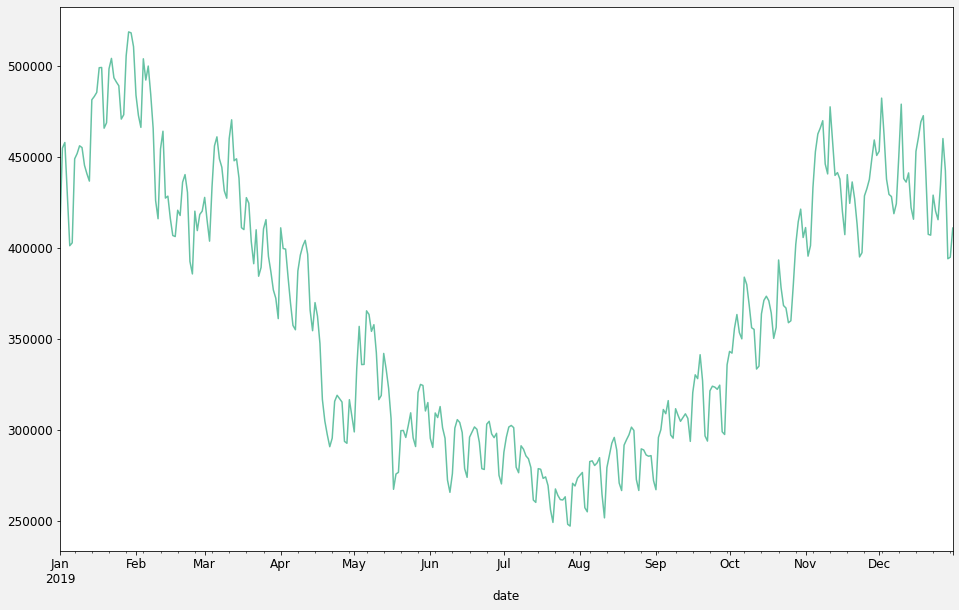

In [244]:
NO_cons = cons.set_index("date").loc[:, "NO"]
NO_cons.plot()

We can see the weekly variation here. If we extend this data over several years, the yearly seasonal pattern would also become clear. Though we will not deal with the latter right now.

We want to deal with the weekly seasonality in our modeling and we have a few choices. The first is to try to remove the seasonal component, and then just forecast the seasonally adjusted data. 

For this we could use several tools, though [fpp3 recommends STL decomposition](https://otexts.com/fpp3/stl.html), which stands for Seasonal and Trend decomposition using Loess. 

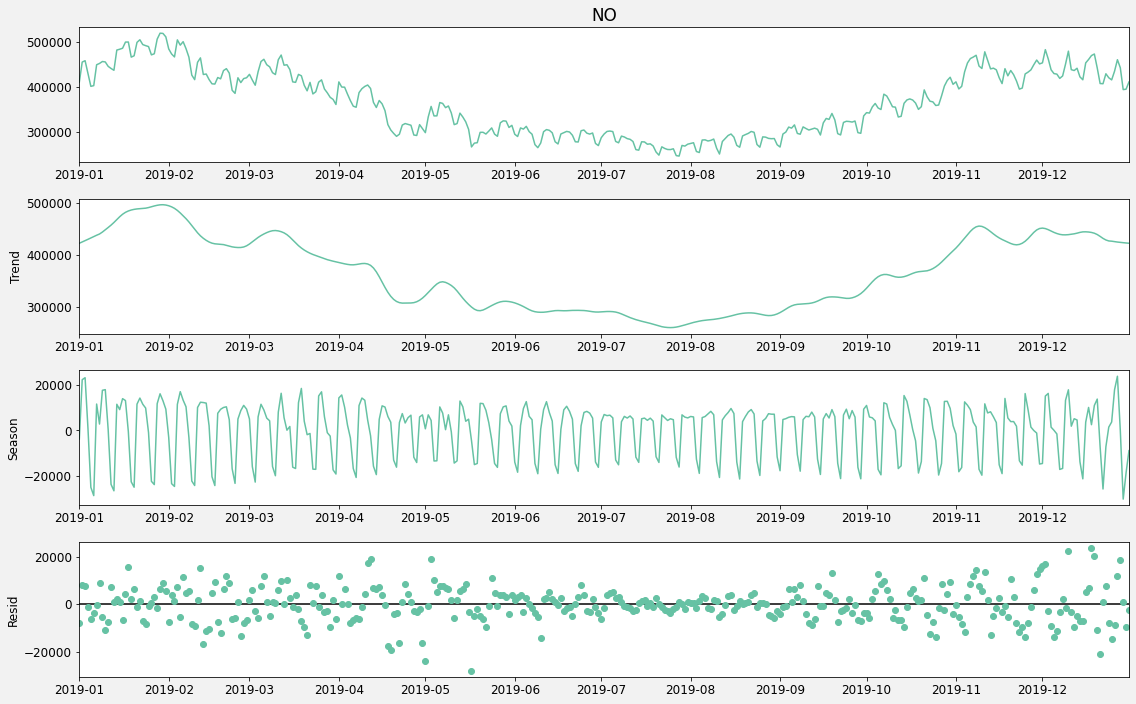

In [245]:
from statsmodels.tsa.seasonal import STL

stl = STL(NO_cons, seasonal=7)
res = stl.fit()
fig = res.plot()

Here we see the series split into 3 components: a smooth trend component, a regular seasonal component and an error or remainder component. 

We can now create a seasonally adjusted series, where the seasonal component is removed and we are left with a series composed of the trend and non-seasonal errors. 

In [246]:
NO_cons_sa = res.trend + res.resid

<AxesSubplot:xlabel='date'>

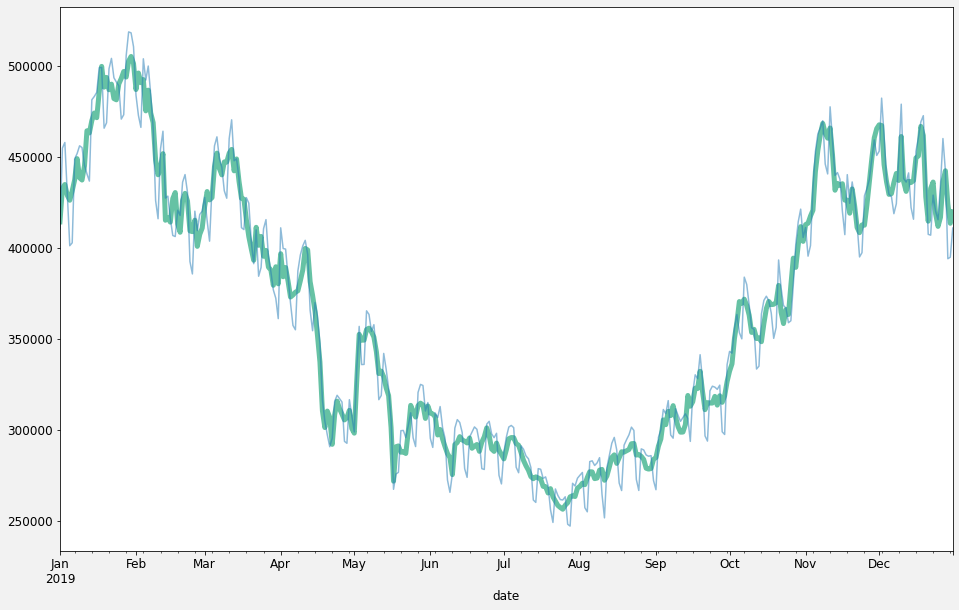

In [249]:
fig, ax = plt.subplots()
NO_cons_sa.plot(ax=ax, linewidth=5)
NO_cons.plot(ax=ax, alpha=.5)

We could then go on and create a forecast model from this data. But if we are interested in including the seasonality in our forecast as well as the trend, we might want to model the seasonality directly in our ARIMA model. You can read more about modeling seasonal ARIMA models [here](https://otexts.com/fpp3/seasonal-arima.html).

First we recognize that the series looks quite non-stationary. Since we have very pronounced seasonality, instead of taking a normal first-difference, we can take a seasonal difference. We can take a look at the differenced series and the ACF and pACF functions

/Users/johannesmauritzen/opt/anaconda3/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


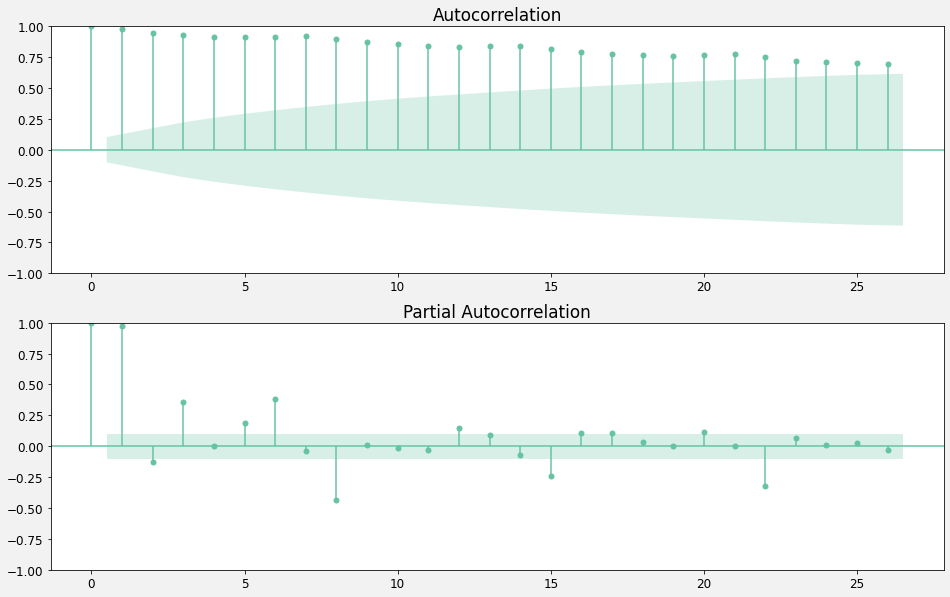

In [250]:
fig, ax = plt.subplots(2,1)
plot_acf(NO_cons, ax=ax[0])
plot_pacf(NO_cons, ax=ax[1])
plt.show()

In [1]:
arimaMod3 = ARIMA(NO_cons, order=(2,0,1), seasonal_order = (2,1,1,7)).fit()
arimaMod3.summary()


NameError: name 'ARIMA' is not defined

Here we have added a seasonal-ARIMA specification. Here the terms are (AR, I, MA, Period). So, if we had (1,0,0,7), that would correspond to adding 1 AR(7) term to the model. In our case, we do a seasonal difference (Monday compared to last Monday), as well as two AR(7) terms and on MA(7) term. In addition we have 2 AR terms and 1 MA term. 

Some experimentation is needed to get a good ARIMA and sARIMA specification (by looking at AIC/BIC values, and testing for stationarity). There are also tools that exist for automatically choosing a specification. These are integrated in the R-tools used in [FPP3](https://otexts.com/fpp3/arima-r.html), but I haven't found a corresponding tool in Python yet. 

We can now generate a forecast based on the seasonal ARIMA model

In [256]:
arimaMod3

In [259]:
forecast_cons = arimaMod3.get_forecast(steps=30).summary_frame()

In [261]:
forecast_cons = forecast_cons.reset_index()


In [263]:
forecast_cons = forecast_cons.rename(columns = {"index":"date"})

<AxesSubplot:xlabel='date'>

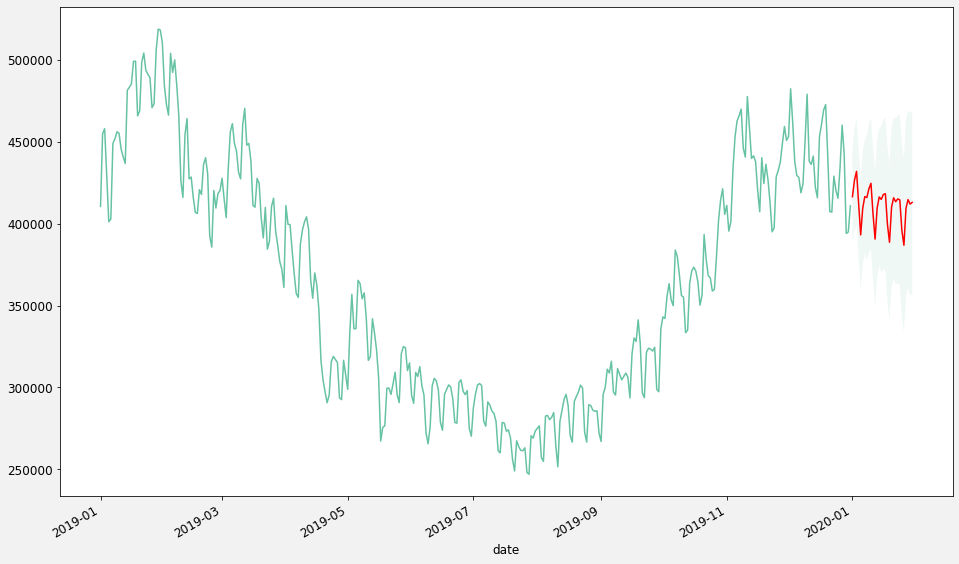

In [264]:
fig, ax = plt.subplots()
ax.plot(forecast_cons["date"], forecast_cons["mean"], color="red")
ax.fill_between(forecast_cons["date"], forecast_cons["mean_ci_lower"], forecast_cons["mean_ci_upper"], alpha=.1)
NO_cons.plot(ax=ax)

## Auto-Arima

Finding an optimal or semi-optimal ARIMA specification manually can sometimes take some time. You could instead try an automatic algorithm that tries to find an optimal ARIMA specification (usually by comparing AIC or BIC values.) [pmdarima](http://alkaline-ml.com/pmdarima/) is one such package available for Python.  

# Assignment

1. In the dataset of consumption, you can also analyse consumption in Denmark. 
* Comparing consumption patterns between Denmark and Norway, how do they differ? How are they similar. 
* Model Danish consumption as a seasonal ARIMA model. Explain how you chose your specification. 
* Make a 30 day forecast of Danish consumption. Explain potential weaknesses of the forecast. What could you do to make it better? 

2. Free problem: Find your own time series data. Find an appropriate ARIMA specification and create a regression with an exogenous variable. Create several scenario forecasts for different paths for the exogenous variable. 